In [3]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import requests
from tqdm import tqdm
import os

# File URL and save location
url = "https://datasets.cellxgene.cziscience.com/d25acbe9-9804-48ba-9e40-10beee03eb25.h5ad"
save_dir = "data/"
filename = "dataset.h5ad"

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)
filepath = os.path.join(save_dir, filename)

# Stream download
response = requests.get(url, stream=True)
response.raise_for_status()

# Total size in bytes
total_size = int(response.headers.get("Content-Length", 0))
block_size = 1024  # 1 KB

# Progress bar
with open(filepath, "wb") as file, tqdm(
    total=total_size, unit="B", unit_scale=True, desc=filename
) as progress_bar:
    for data in response.iter_content(block_size):
        file.write(data)
        progress_bar.update(len(data))

print(f"Download complete: {filepath}")

dataset.h5ad: 100%|██████████| 6.51G/6.51G [04:05<00:00, 26.5MB/s]  

Download complete: data/dataset.h5ad


In [5]:
import scanpy as sc

# Load the file
adata = sc.read_h5ad("data/dataset.h5ad")

In [6]:
diseased = adata.obs[adata.obs["disease"] == "Alzheimer disease"]
normal = adata.obs[adata.obs["disease"] != "Alzheimer disease"]
print(f"number of diseased samples: {diseased.shape[0]}")
print(f"number of normal samples: {normal.shape[0]}")

number of diseased samples: 310773
number of normal samples: 113755


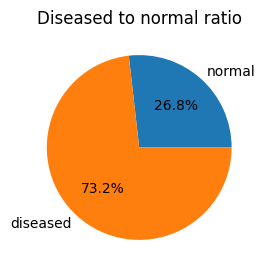

In [7]:
import matplotlib.pyplot as plt

total_size = diseased.shape[0] + normal.shape[0]
diseased_percent = diseased.shape[0] / total_size
normal_percent = normal.shape[0] / total_size
plt.figure(figsize=(3,3))
plt.pie([normal_percent, diseased_percent], labels=["normal", "diseased"], autopct='%1.1f%%')

plt.title("Diseased to normal ratio")
plt.show()

In [ ]:
import pandas as pd

cell_type = "microglial cell"
results = {}

for name,data in [("diseased", diseased), ("normal", normal)]:

    cell = data[data["cell_type"] == cell_type]
    cell_names = list(cell.index)
    ids = adata.obs_names.get_indexer(cell_names)

    df = pd.DataFrame(adata.X[ids].toarray(), columns = adata.var.feature_name)
    mean_expression = df.mean(axis=0)

    expression_to_gene = {v:k for k,v in mean_expression.items()}
    sorted_expression = sorted(expression_to_gene.keys(), reverse=True)

    genes = []
    for i in range(10):
        genes.append(expression_to_gene[sorted_expression[i]])

    results[name] = genes

pd.DataFrame(results)

In [ ]:
import scanpy as sc

sc.pp.neighbors(adata)  # Compute the neighborhood graph
sc.tl.umap(adata)